In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/y_dataset1_window.npy
/kaggle/input/syntheticDataset_O50.csv
/kaggle/input/X_dataset1_window.npy


In [7]:
# GPU에서 잘 돌아가는지 확인
import tensorflow as tf

device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
print(device)

2025-05-29 08:45:42.156154: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748508342.380108      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748508342.448650      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/GPU:0


In [8]:
# 데이터 불러오기
df = pd.read_csv('/kaggle/input/syntheticDataset_O50.csv') 
df

,object_ID,request_time
0,5,2.961472
1,25,3.274127
2,2,3.785475
3,2,4.455687
4,4,5.288994
...,...,...
292141,39,304330.451276
292142,39,304352.296649
292143,39,304405.469075
292144,39,304442.964190


In [9]:
m = 20
k = 10

object_ids = df['object_ID'].unique()
object_ids.sort()
num_objects = len(object_ids) # Unique obeject 개수 (50개)

In [10]:
X = np.load("/kaggle/input/X_dataset1_window.npy")
y = np.load("/kaggle/input/y_dataset1_window.npy")

print("X.shape (reshaped):", X.shape)
print("y.shape (reshaped):", y.shape)

X.shape (reshaped): (131100, 20, 1)
y.shape (reshaped): (131100, 10, 1)


In [11]:
from tensorflow.keras.layers import (
    Input, LSTM, Dense, TimeDistributed, RepeatVector
)
from tensorflow.keras.models import Model

In [12]:
def build_seq2seq_model(m, k):
    # ----- Encoder -----
    encoder_inputs = Input(shape=(m, 1))  # Input shape: (sequence_length, 1)

    # Two-layer encoder with 128 and 64 hidden units
    encoder_lstm_1 = LSTM(128, return_sequences=True)
    encoder_lstm_2 = LSTM(64, return_state=True)

    x = encoder_lstm_1(encoder_inputs)
    encoder_outputs, state_h, state_c = encoder_lstm_2(x)
    encoder_states = [state_h, state_c]  # Final encoder states passed to decoder

    # ----- Decoder -----
    decoder_inputs = RepeatVector(k)(encoder_outputs)  # Repeat context vector for k time steps

    # Two-layer decoder with 128 and 64 hidden units
    decoder_lstm_1 = LSTM(128, return_sequences=True)
    decoder_lstm_2 = LSTM(64, return_sequences=True)

    x = decoder_lstm_1(decoder_inputs, initial_state=encoder_states)
    decoder_outputs = decoder_lstm_2(x)

    # Predict one value per time step
    decoder_dense = TimeDistributed(Dense(1))
    output_seq = decoder_dense(decoder_outputs)

    # Compile the model with MSE loss and MAE metric
    model = Model(encoder_inputs, output_seq)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model

In [13]:
from sklearn.model_selection import train_test_split

batch_size = int(len(X) * 0.1)
print("Batch size:", batch_size)

model = build_seq2seq_model(m, k)
model.fit(X, y, epochs=30, batch_size=batch_size)

y_pred = model.predict(X)  # 전체 X에 대해 예측

print("예측 결과 형태:", y_pred.shape)

Batch size: 13110


I0000 00:00:1748508356.881863      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/30


I0000 00:00:1748508364.330231     103 cuda_dnn.cc:529] Loaded cuDNN version 90300


10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 465ms/step - loss: 0.0048 - mae: 0.0566
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 464ms/step - loss: 0.0011 - mae: 0.0199
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 464ms/step - loss: 9.2722e-04 - mae: 0.0180
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 464ms/step - loss: 7.9617e-04 - mae: 0.0137
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 464ms/step - loss: 5.4019e-04 - mae: 0.0138
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 464ms/step - loss: 4.6341e-04 - mae: 0.0112
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 464ms/step - loss: 4.2181e-04 - mae: 0.0102
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 464ms/step - loss: 3.9346e-04 - mae: 0.0101
Epoch 9/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 463ms/step - loss: 3.5223e-04 - mae: 0.0094
Epoch 10/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 464ms/step - loss: 3.2315e-04 - mae: 0.0089
Epoch 11/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 464ms/step - loss: 3.2438e-04 - mae: 0.0089
Epoch 12/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 464ms/step - loss: 3.0687e-04 - mae: 0.

In [20]:
M = 5
top_objects_each_t = []
for i in range(len(y_pred)):
    next_probs = y_pred[i, 0].flatten()
    top_indices = next_probs.argsort()[-M:][::-1]
    top_objects_each_t.append(list(top_indices))

In [21]:
# 실제 요청과 fake 요청을 합치는 merge 방식
merged_requests = []
fake_insert_idx = 0
insert_interval = 5

actual_requests = df.sort_values('request_time')['object_ID'].tolist()

for t, req in enumerate(actual_requests):
    merged_requests.append(req)
    if fake_insert_idx < len(top_objects_each_t) and t % insert_interval == 0:
        fake_objs = top_objects_each_t[fake_insert_idx]
        merged_requests.extend(fake_objs)
        fake_insert_idx += 1

In [24]:
# 기본 LRU 캐시와 성능 비교
# LRU 캐시 시뮬레이터 코드
from collections import OrderedDict

class LRUCache:
  def __init__(self, capacity):
    self.capacity = capacity
    self.cache = OrderedDict()
    self.hit = 0
    self.miss = 0

  def request(self, obj_id):
    if obj_id in self.cache:
        self.cache.move_to_end(obj_id)
        self.hit += 1
        return 1
    else:
        self.miss += 1
        if len(self.cache) >= self.capacity:
            self.cache.popitem(last=False) # 길이를 넘으면 pop
        self.cache[obj_id] = True # 최근 것 push
        return 0

  def get_hit_ratio(self):
    total = self.hit + self.miss
    return self.hit / total if total > 0 else 0

In [25]:
# LRU 캐시 시뮬레이션 실행
cache_size = 20
lru_deep = LRUCache(cache_size)
hits_deep = []

for obj_id in merged_requests:
    hit = lru_deep.request(obj_id)
    hits_deep.append(hit)

deep_cache_hit_ratio = round(lru_deep.get_hit_ratio(), 4)
print("DeepCache(LRU + 예측) 캐시 hit ratio:", deep_cache_hit_ratio)

DeepCache(LRU + 예측) 캐시 hit ratio: 0.731


In [26]:
# 요청 로그를 읽어서 LRU 시뮬레이션 수행
import pandas as pd

requests = df['object_ID'].tolist()

lru_traditional = LRUCache(cache_size)
hits_trad = []

for obj_id in requests:
    hit = lru_traditional.request(obj_id)
    hits_trad.append(hit)

traditional_lru_hit_ratio = round(lru_traditional.get_hit_ratio(), 4)
print("LRU 캐시 hit ratio:", traditional_lru_hit_ratio)

LRU 캐시 hit ratio: 0.6948


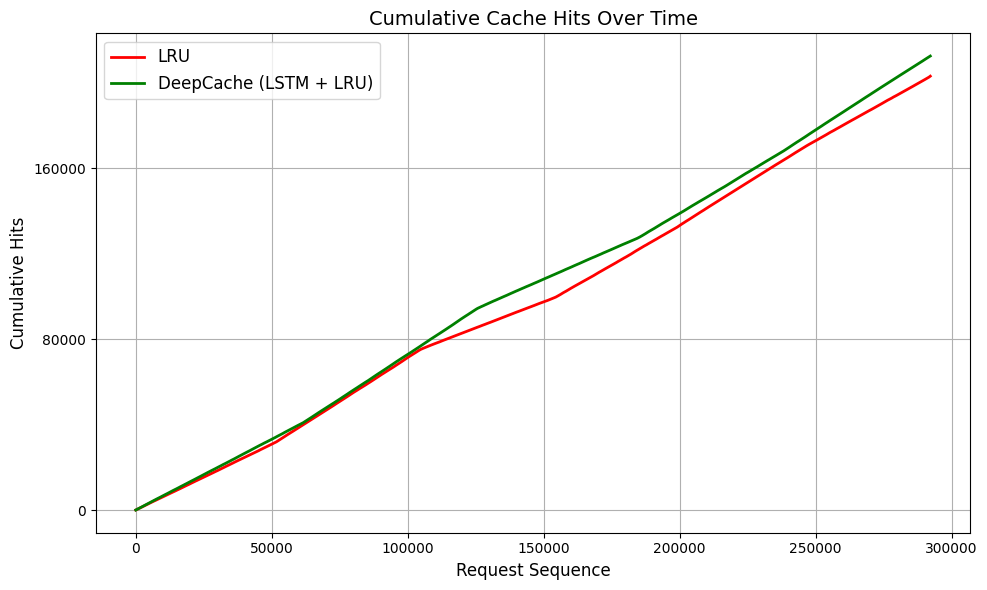

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# hits 리스트가 이미 0/1로만 구성되어 있다고 가정
hits_deep = np.array(hits_deep, dtype=int)
hits_trad = np.array(hits_trad, dtype=int)

min_len = min(len(hits_trad), len(hits_deep))

hits_trad = hits_trad[:min_len]
hits_deep = hits_deep[:min_len]
x = np.arange(1, min_len + 1)

x = np.arange(1, len(hits_trad) + 1)
cumulative_deep = np.cumsum(hits_deep)
cumulative_trad = np.cumsum(hits_trad)

# 샘플링 간격
step = 10
x = np.arange(1, min_len + 1)[::step]
cumulative_trad = cumulative_trad[::step]
cumulative_deep = cumulative_deep[::step]

# y축 눈금 간격 설정
y_max = max(cumulative_deep.max(), cumulative_trad.max())
yticks = np.arange(0, y_max + 1, 80000) 

# 그래프 출력
plt.figure(figsize=(10, 6))
plt.plot(x, cumulative_trad, label='LRU', color='red', linewidth=2)
plt.plot(x, cumulative_deep, label='DeepCache (LSTM + LRU)', color='green', linewidth=2)
plt.xlabel('Request Sequence', fontsize=12)
plt.ylabel('Cumulative Hits', fontsize=12)
plt.title('Cumulative Cache Hits Over Time', fontsize=14)
plt.yticks(yticks, fontsize=10)  # ✅ y축 간격 설정
plt.xticks(fontsize=10)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()